In [ ]:
# polara
!pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

# ipypb:
!pip install ipypb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-57xj0cbi/polara_4d7b6af3f6a547a1b82eb2773f883aff
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-57xj0cbi/polara_4d7b6af3f6a547a1b82eb2773f883aff
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import zipfile

import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import svds
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, norm
from polara.lib.tensor import hooi

from dataprep import transform_indices, reindex_data
from evaluation import downvote_seen_items, topn_recommendations, model_evaluate
import matplotlib as plt

In [ ]:
from polara.preprocessing.dataframes import leave_one_out

In [ ]:
def generate_interactions_matrix(data, data_description, rebase_users=False):
    '''
    Convert pandas dataframe with interactions into a sparse matrix.
    Allows reindexing user ids, which help ensure data consistency
    at the scoring stage (assumes user ids are sorted in scoring array).
    '''
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data[data_description['users']].values
    if rebase_users:
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data[data_description['items']].values
    feedback = data[data_description['feedback']].values
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items))


# getting data from Kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle (8).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2229         90  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14           1065         33  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                      8KB  2023-02-01 1

In [ ]:
competition_name = "skoltech-recommender-systems-challenge-2023"

In [ ]:
!kaggle competitions download -c {competition_name}

skoltech-recommender-systems-challenge-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
with zipfile.ZipFile("skoltech-recommender-systems-challenge-2023.zip","r") as z:
    z.extractall(".")

In [ ]:
training_source = pd.read_csv('training')

In [ ]:
testset_source = pd.read_csv('testset')

# Convenience functions

In [ ]:
def plot_monthly_activity(data, ax=None, label=None, timeid='timestamp'):
    return (data
        .set_index(pd.to_datetime(data[timeid], unit='s'))
        .resample('M').size()
        .plot(ax=ax, logy=True, label=label, xlabel='Month',
              title='Monthly rating activity', legend=label is not None)
    )

## data splitting

In [ ]:
def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the `warm-start` evaluation strategy.

    Parameters
    ----------
    data : pd.DataFrame
        The input dataset containing columns `userid`, `movieid`, and `timestamp`.
    time_split_q : float, optional
        The quantile value used to split the dataset based on the `timestamp` column.
        Default is 0.95.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of three pandas DataFrames: training, testset, and holdout.
        `training` is a subset of `data` used for training the recommender system.
        `testset` is a subset of `data` used for generating recommendations for the test users.
        `holdout` is a subset excluded from `testset` containing only the most recent interactions for each test user.

    Notes
    -----
    The function splits the input `data` into three subsets: `training`, `testset`, and `holdout`.
    The split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value.
    The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`.
    The set of users in `training` is disjoint with the set of users in the `testset`, which implements the `warm-start` scenario.
    """    
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)
    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['userid'], keep='first')
    )
    # the holdout dataframe contains interactions closest to certain timepoint from the right,
    # i.e., the corresponding items are the first in each test user profile after this timepoint
    training = rest_.query('userid not in @holdout_.userid')
    train_items = training.movieid.unique()
    testset_ = rest_.query('userid in @holdout_.userid and movieid in @train_items')
    test_users = testset_.userid.unique()
    holdout = holdout_.query(
        # if user is not in `test_users` then no evluation is possible,
        # if item is not in `train_items` it's cold start -> must be excluded
        'userid in @test_users and movieid in @train_items'
    ).sort_values('userid')
    testset = testset_.query(
        # make sure testset and holdout contain the same set of users
        'userid in @holdout.userid'
    ).sort_values('userid')
    return training, testset, holdout

## kaggle solution format

In [ ]:
def save_solution(recs_array, useridx, itemidx, filepath):
    """
    Save a solution for Kaggle competition in the required format.

    Parameters 
    ----------
    recs_array (numpy.ndarray): Array of recommended items. 
    useridx (pandas.Index): Test user indices in the original (source) representation. 
    itemidx (pandas.Index): Mapping from internal to orignial representation of item indices. 
    filepath (str): Path to save the solution file. 

    Returns
    -------
    None: The function saves the solution file in the csv format at the specified path. 

    Notes
    -----
    The code creates a dataframe containing user IDs and a list of recommended items for each user.
    It then melts the dataframe so that each row contains one recommended item per user.
    Finally, it saves the melted dataframe to a file at the specified filepath.
    """
    rec_items = itemidx.take(recs_array).values
    solution = pd.DataFrame({
        'userid': useridx,
        'movieid': [list(recs) for recs in rec_items]
    })
    sol_melt = solution.set_index('userid')['movieid'].explode().reset_index()
    sol_melt.to_csv(filepath, index=False)

To submit a solution, you can use he following command directly from a notebook cell:  

```
!kaggle competitions submit -c {competition_name} -f {filepath} -m 'my new submission'
```

# Evaluation setup

In [ ]:
topn = 20

In [ ]:
def evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    
    ndcg_pu = 1.0 / np.log2(hit_rank + 1)
    
    ndcg = np.sum(ndcg_pu) / n_test_users
    
    return ndcg

In [ ]:
testset_source.nunique()

userid          2963
movieid        17102
rating            10
timestamp    1346560
dtype: int64

In [ ]:
# val data
train_val_, test_val_, holdout_val_ = timepoint_split(training_source, time_split_q=0.96)

In [ ]:
holdout_val_.shape

(1379, 4)

In [ ]:
train_val, data_index =  transform_indices(train_val_, 'userid', 'movieid')
test_val = reindex_data(test_val_, data_index, fields='items')
holdout_val = reindex_data(holdout_val_, data_index, fields='items')

In [ ]:
# def transform_data(train, test, holdout=None, userid='userid', itemid='movieid'):
#     train_new, data_index = transform_indices(train, userid, itemid)
#     testset_new = reindex_data(test, data_index, fields='items')
#     if holdout is None:
#         return train_new, testset_new, data_index
#     holdout_new = reindex_data(holdout, data_index, fields='items')
#     return train_new, testset_new, holdout_new, data_index

# train_val, testset_val, holdout_val, data_index =  transform_data(train_val_, testset_val_, holdout_val_, )

# assert not holdout_val['movieid'].eq(-1).any()

# assert not testset_val['movieid'].eq(-1).any()

# 50 pts baseline

### grid-search

In [ ]:
#ranks = [b* 2**n for n in range(3, 10) for b in [1,2,3,4]]
ranks = [i for i in range(250, 600, 5)]
ranks

[250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 550,
 555,
 560,
 565,
 570,
 575,
 580,
 585,
 590,
 595]

In [ ]:
def svd_grid_search(ranks,training, testset, holdout, data_description, topn=20):
    max_rank = max(ranks)
    config = {'rank': max_rank}
    item_factors = build_svd_model(config, training, data_description)
    results = {}
    for rank in ranks:
        item_factors_trunc = item_factors[:, :rank]
        scores = svd_model_scoring(item_factors_trunc, testset, data_description)
        recs = topn_recommendations(scores, topn=topn)
        results[rank] = evaluate(recs, holdout, data_description)
    return results   

def build_svd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    *_, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def svd_model_scoring(params, data, data_description):
    item_factors = params
    
    test_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    
    downvote_seen_items(scores, data, data_description)
    return scores

In [ ]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)

In [ ]:
svd_results = svd_grid_search(ranks, train_val, test_val, holdout_val, data_description, topn=topn)

### best model

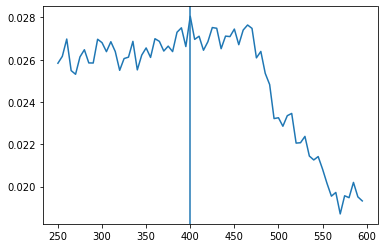

In [ ]:
best_svd_rank = pd.Series(svd_results).idxmax()

ax = pd.Series(svd_results).plot()
ax.axvline(best_svd_rank)

In [ ]:
best_svd_rank

400

In [ ]:
def transform_data(train, test, holdout=None, userid='userid', itemid='movieid'):
    train_new, data_index = transform_indices(train, 'userid', 'movieid')
    testset_new = reindex_data(test, data_index, fields='items')
    if holdout is None:
        return train_new, testset_new, data_index
    holdout_new = reindex_data(holdout, data_index, fields='items')
    
    return train_new, testset_new, holdout_new, data_index

In [ ]:
training, testset, data_index_source = transform_data(training_source, testset_source)

In [ ]:
data_description_source = dict(
    users = data_index_source['users'].name,
    items = data_index_source['items'].name,
    feedback = 'rating',
    n_users = len(data_index_source['users']),
    n_items = len(data_index_source['items']),
)

In [ ]:
best_config = {'rank': best_svd_rank}
item_factors = build_svd_model(best_config, training, data_description_source)
scores = svd_model_scoring(item_factors, testset, data_description_source)
recs = topn_recommendations(scores, topn=topn)

In [ ]:
#2963,20 
recs.shape

(2963, 20)

In [ ]:
test_user_indices = pd.Index(testset_source['userid']).drop_duplicates

In [ ]:
data_index_source['items']

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            51754, 51820, 51828, 52155, 52362, 52386, 52492, 52509, 52993,
            53859],
           dtype='int64', name='movieid', length=18264)

In [ ]:
svd_sol_filepath = 'svd_recs.csv'
save_solution(recs, test_user_indices, data_index_source['items'], svd_sol_filepath)

# 75 pts baseline

### grid-search

In [8]:
def generate_list():
    values = []
    current_value = 0.21
    while current_value <= 0.60:
        values.append(round(current_value, 2))
        current_value += 0.01
    return values

In [11]:
scalings = generate_list()
scalings

[0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59]

In [ ]:
def ssvd_grid_search(ranks, scalings, training, testset, holdout, data_description, topn=20):
    max_rank = max(ranks)
    config = {'rank': max_rank}
    results = {}
    
    for scaling in tqdm(scalings):
        config['scaling'] = scaling
        item_factors, *rest = build_ssvd_model(config, training, data_description)
        for rank in ranks:
            item_factors_trunc = item_factors[:, :rank]
            new_params = (item_factors_trunc,)+tuple(rest)
            scores = ssvd_model_scoring(new_params, testset, data_description)
            recs = topn_recommendations(scores, topn=topn)
            results[(rank, scaling)] = evaluate(recs, holdout, data_description)
    return results   

def build_ssvd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    
    scaled_matrix, scaling_weights = rescale_matrix(source_matrix, config['scaling'])
    
    *_, vt = svds(scaled_matrix, k=config['rank'], return_singular_vectors='vh')
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, scaling_weights

def rescale_matrix(matrix, scaling_factor):
    frequencies = matrix.getnnz(axis=0)
    scaling_weights = np.power(frequencies, 0.5*(scaling_factor-1))
    return matrix.dot(diags(scaling_weights)), scaling_weights

def ssvd_model_scoring(params, data, data_description):
    item_factors, scaling_weights = params
    
    test_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    
    downvote_seen_items(scores, data, data_description)
    return scores

In [ ]:
ssvd_results = ssvd_grid_search(ranks,scalings, train_val, test_val, holdout_val, data_description, topn=topn)

  0%|          | 0/39 [00:09<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
best_ssvd_rank = pd.Series(ssvd_results).idxmax()

ax = pd.Series(ssvd_results).plot()
ax.axvline(best_ssvd_rank)

### best model

In [ ]:
sorted_results = sorted(ssvd_results.items(), key=lambda item: item[1], reverse=True)
sorted_results

In [ ]:
rank_scaling_list = []
for val in sorted_results[:11]:
  rank_scaling_list.append(val[0])

In [ ]:
for rank_scaling in rank_scaling_list:
  best_config = {'rank': rank_scaling[0], 'scaling': rank_scaling[1]}
  ssvd_params = build_ssvd_model(best_config, training, data_description_source)
  sscores = ssvd_model_scoring(ssvd_params, testset, data_description_source)
  srecs = topn_recommendations(sscores, topn=topn)
  test_user_indices = pd.Index(testset_source['userid']).drop_duplicates()
  ssvd_sol_filepath = f'ssvd_recs_{rank_scaling[0]}_{rank_scaling[1]}.csv'
  save_solution(srecs, test_user_indices, data_index_source['items'], ssvd_sol_filepath)  
  print(rank_scaling)

In [ ]:
submission_with_polara = 'ssvd_recs_580_0.35.csv'

In [ ]:
!kaggle competitions submit -c {competition_name} -f {submission_with_polara} -m 'my new submission'

100% 634k/634k [00:00<00:00, 1.74MB/s]
Successfully submitted to Skoltech Recommender Systems Challenge 2023

In [ ]:
best_config

In [ ]:
best_config = dict(
    zip(
        ['rank', 'scaling'],
        pd.Series(ssvd_results).idxmax()
    )
)
best_config

In [ ]:
(
    pd.Series(ssvd_results)
    .unstack(level=1)
    .style
    .format('{:.4f}')
    .background_gradient(high=0.2, axis=None)
)

In [ ]:
ssvd_params = build_ssvd_model(best_config, training, data_description_source)
scores = ssvd_model_scoring(ssvd_params, testset, data_description_source)
srecs = topn_recommendations(scores, topn=topn)

In [ ]:
srecs

array([[ 194,  222,  755, ...,  631,  788, 1044],
       [ 981, 1361,  174, ...,  756,  729,  293],
       [  62,  163,  376, ...,  224,  537,  167],
       ...,
       [ 958,  981,  780, ...,  279,  967, 1878],
       [ 983,  981, 1080, ..., 1528, 1085, 1087],
       [ 671,  955,  667, ..., 2366,  229,  472]])

In [ ]:
test_user_indices = pd.Index(testset_source['userid']).drop_duplicates()
ssvd_sol_filepath = 'ssvd_recs.csv'
save_solution(srecs, test_user_indices, data_index_source['items'], ssvd_sol_filepath)

In [ ]:
!kaggle competitions submit -c {competition_name} -f {ssvd_sol_filepath} -m 'my new submission'

100% 633k/633k [00:00<00:00, 2.57MB/s]
Successfully submitted to Skoltech Recommender Systems Challenge 2023